In [ ]:
# analysis directory: /ghdevhome/home/schen/epigen/om-227/

In [2]:
from matplotlib import pyplot
from pandas import read_csv, DataFrame, Series, isnull, read_pickle
from numpy import quantile, nan, concatenate, log, std, mean
import seaborn

In [3]:
features = read_csv('omni_v2_sample_metadata_Sheet1.tsv', header=0, sep='\t')
features.head(2)

,run_sample_id,index,index2,sample_sheet,accession_id,PlateWell_ID,batch_name,flowcell_ID,input_ng_PG,input_ng_TS,...,Sample_Type,cancer_type,bait_ng,bait_blending,MBDS_buffer_mM,methyl-carrier,MW1_buffer_mM,MSRE,LP_200_800bp_Hypo_ng_uL,LP_200_800bp_Hyper_ng_uL
0,C0013809,CGCTCAATGG,CAAGGCGCGC,210322_A01021_0237_AH2N5MDSX2_CMRDNHLA.csv,NaN,NaN,OMNI_001,H2N5MDSX2,10,10.0,...,PCR Refresh,normal,20.20,100_1,NaN,NaN,NaN,NaN,NaN,NaN
1,C0013810,TCATAGAGCG,CATTTCAGGG,210322_A01021_0237_AH2N5MDSX2_CMRDNHLA.csv,NaN,NaN,OMNI_001,H2N5MDSX2,10,10.0,...,PCR Refresh,normal,20.25,80_1,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
pname = "pastel"
cn_color = seaborn.color_palette("Set2")[2:4]
cn_color.reverse()

In [5]:
mdata = read_csv('counting-output/l2_counts.tsv', header=0, sep='\t')
mdata = mdata.T
mdata.columns = mdata.iloc[0].to_list()
mdata = mdata.iloc[1:]
region_list = mdata.columns.to_list()[:-1]
mdata["MSRE"] = nan
mdata["accession_id"] = nan
mdata["cancer_type"] = nan
mdata["input"] = nan
for idx, d2 in mdata.iterrows():
    mdata.loc[idx, "MSRE"] = features[features["run_sample_id"]==idx]["MSRE"].item()
    mdata.loc[idx, "cancer_type"] = features[features["run_sample_id"]==idx]["cancer_type"].item()
    mdata.loc[idx, "accession_id"] = features[features["run_sample_id"]==idx]["accession_id"].item()
    mdata.loc[idx, "input"] = features[features["run_sample_id"]==idx]["input_ng_TS"].item()
mdata.head(2)

,1_10002945_10003896,1_100315326_100316120,1_1003813_1004865,1_100435187_100436167,1_100503312_100504500,1_10057059_10058046,1_100598041_100598939,1_100714848_100715562,1_100731266_100732388,1_100817690_100819049,...,Y_2802900_2804561,Y_6777175_6777489,Y_6778279_6779833,Y_7140665_7141373,Y_7141558_7143307,ctrl_sum,MSRE,accession_id,cancer_type,input
C0018262,5,7,16,11,8,27,14,3,14,11,...,0,0,0,0,0,131897,MSRE(-),A0309861,lung,22.2
C0018225,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,71197,MSRE(+),A0322811,lung,14.9


In [6]:
msre_status = list(set(mdata["MSRE"].tolist()))
accession_ids = list(set(mdata["accession_id"].to_list()))
len(accession_ids)

47

In [6]:
mdata["cancer_type"].value_counts()

lung          40
normal        12
bladder        6
melanoma       6
prostate       4
esophageal     4
CRC            4
cholangio      2
CUP            2
HNSCC          2
pancrea        2
gastric        2
cervical       2
breast         2
SeraCare       2
urothelial     2
Name: cancer_type, dtype: int64

In [6]:
clean_regions = []
for r in region_list:
    if "X" in r or "Y" in r:
        continue
    clean_regions.append(r)

In [10]:
from umap import UMAP
reducer = UMAP()
embedding = reducer.fit_transform(mdata[clean_regions])

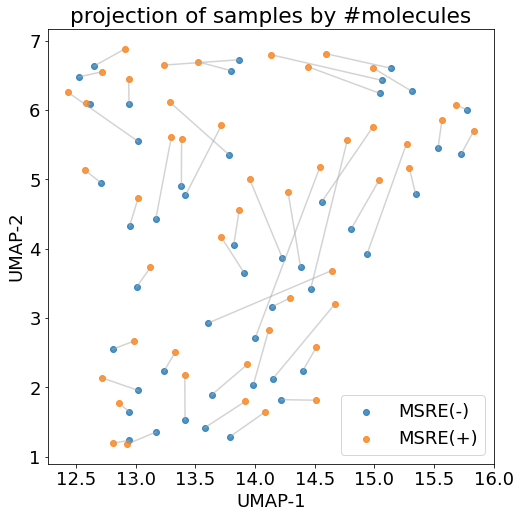

In [11]:
pyplot.rcParams['figure.figsize'] = [8, 8]
pyplot.rcParams.update({'font.size': 18})
for ms in msre_status:
    _ = pyplot.scatter(embedding[mdata["MSRE"]==ms,0], embedding[mdata["MSRE"]==ms,1], alpha=0.8, label=ms)
    
for a_id in accession_ids:
    _ = pyplot.plot(embedding[mdata["accession_id"]==a_id, 0], embedding[mdata["accession_id"]==a_id, 1], alpha=0.5, color="darkgrey")
    
_ = pyplot.xlabel("UMAP-1", fontsize=18)
_ = pyplot.ylabel("UMAP-2", fontsize=18)
_ = pyplot.legend()
_ = pyplot.title("projection of samples by #molecules")

## total molecules (unnormalized & normalized)

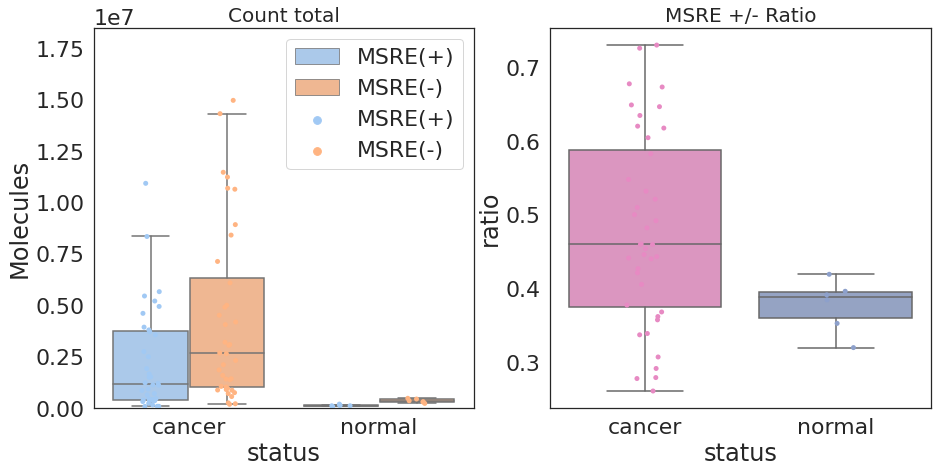

In [9]:
pyplot.rcParams['figure.figsize'] = [15, 7]
pyplot.rcParams["xtick.labelsize"] = 20
pyplot.rcParams["ytick.labelsize"] = 20
seaborn.set(font_scale=2)
seaborn.set_style(style='white') 

_ = pyplot.subplot(1,2,1)
pd = DataFrame(data={"Molecules": [], "MSRE": []})
for ms in msre_status:
    md = mdata[(mdata["MSRE"]==ms) & (mdata["accession_id"]!="SC")]
    ct = md[region_list].sum(axis=1)
    cancer_status = md["cancer_type"].to_list()
    for i in range(len(cancer_status)):
        if cancer_status[i] != "normal":
            cancer_status[i] = "cancer"
    pd = pd.append(DataFrame(data={"Molecules": ct, "MSRE": ms, "status":cancer_status}))
ax_box = seaborn.boxplot(x="status", y="Molecules", hue="MSRE", data=pd, showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="status", y="Molecules", hue="MSRE", data=pd, palette=pname, dodge=True)
_ = pyplot.title("Count total", fontsize=20)
_ = pyplot.legend(loc='upper right', bbox_to_anchor=(1, 1))
_ = pyplot.ylim(-0.05, 18500000)

_ = pyplot.subplot(1,2,2)
cancer_status = []
ratios = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    md = mdata[mdata["accession_id"]==a_id]
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = int(dpos[region_list].sum(axis=1))
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = int(dneg[region_list].sum(axis=1))
    rt = rpos / rneg
    ratios.append(rt)
    if md[md["MSRE"]=="MSRE(+)"]["cancer_type"].item()=="normal":
        cancer_status.append("normal")
    else:
        cancer_status.append("cancer")
        
rd = DataFrame(data={"ratio":ratios, "status":cancer_status})
ax_box = seaborn.boxplot(x="status", y="ratio", data=rd, showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="status", y="ratio", data=rd, palette=cn_color)
_ = pyplot.title("MSRE +/- Ratio", fontsize=20)

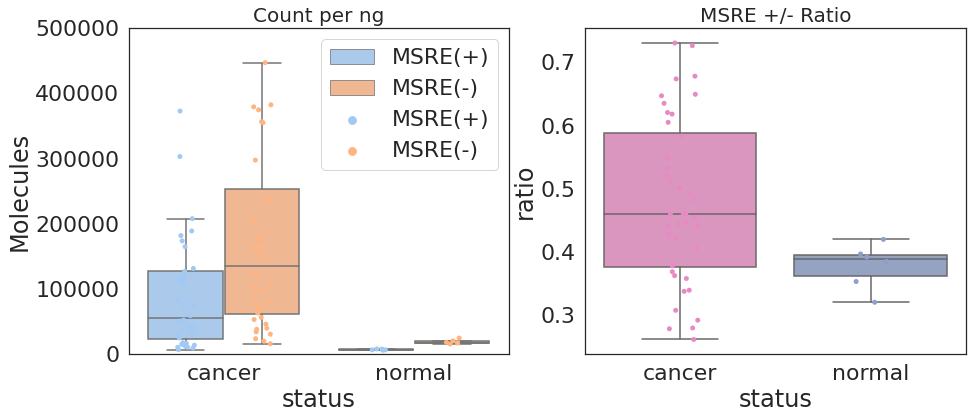

In [9]:
## normalize by input
pyplot.rcParams['figure.figsize'] = [15, 6]
pyplot.rcParams.update({'font.size': 18})

_ = pyplot.subplot(1,2,1)
pd = DataFrame(data={"Molecules": [], "MSRE": []})
for ms in msre_status:
    md = mdata[(mdata["MSRE"]==ms) & (mdata["accession_id"]!="SC")]
    ct = md[region_list].sum(axis=1) / md["input"]
    cancer_status = md["cancer_type"].to_list()
    for i in range(len(cancer_status)):
        if cancer_status[i] != "normal":
            cancer_status[i] = "cancer"
    pd = pd.append(DataFrame(data={"Molecules": ct, "MSRE": ms, "status":cancer_status}))
ax_box = seaborn.boxplot(x="status", y="Molecules", hue="MSRE", data=pd, showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="status", y="Molecules", hue="MSRE", data=pd, palette=pname, dodge=True)
_ = pyplot.title("Count per ng", fontsize=20)
_ = pyplot.legend(loc='upper right', bbox_to_anchor=(1, 1))
_ = pyplot.ylim(-0.05, 500000)

_ = pyplot.subplot(1,2,2)
cancer_status = []
ratios = []
rposes = []
rnegs = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    md = mdata[mdata["accession_id"]==a_id]
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = int(dpos[region_list].sum(axis=1)) / dpos["input"].item()
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = int(dneg[region_list].sum(axis=1))  / dneg["input"].item()
    rposes.append(rpos)
    rnegs.append(rneg)
    rt = rpos / rneg
    ratios.append(rt)
    if md[md["MSRE"]=="MSRE(+)"]["cancer_type"].item()=="normal":
        cancer_status.append("normal")
    else:
        cancer_status.append("cancer")
        
rd = DataFrame(data={"rpos": rposes, "rneg": rnegs, "ratio":ratios, "status":cancer_status})
ax_box = seaborn.boxplot(x="status", y="ratio", data=rd, showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="status", y="ratio", data=rd, palette=cn_color)
_ = pyplot.title("MSRE +/- Ratio", fontsize=20)

## positive controls

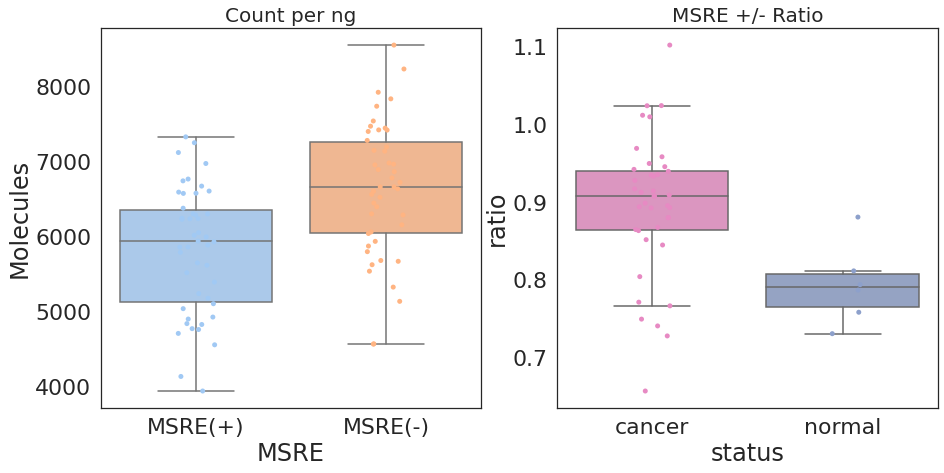

In [11]:
pyplot.rcParams['figure.figsize'] = [15, 7]
pyplot.rcParams["xtick.labelsize"] = 20
pyplot.rcParams["ytick.labelsize"] = 20
seaborn.set(font_scale=2)
seaborn.set_style(style='white') 
pname = "pastel"

_ = pyplot.subplot(1,2,1)
pd = DataFrame(data={"Molecules": [], "MSRE": []})
for ms in msre_status:
    md = mdata[(mdata["MSRE"]==ms) & (mdata["accession_id"]!="SC")]
    ct =  [i / j for i, j in zip(md["ctrl_sum"], md["input"].to_list())]
    pd = pd.append(DataFrame(data={"Molecules": ct, "MSRE": ms}))
ax_box = seaborn.boxplot(x="MSRE", y="Molecules", data=pd, showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="MSRE", y="Molecules", data=pd, palette=pname)
_ = pyplot.title("Count per ng", fontsize=20)

_ = pyplot.subplot(1,2,2)
cancer_status = []
ratios = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    md = mdata[mdata["accession_id"]==a_id]
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = dpos["ctrl_sum"].item() / dpos["input"].item()
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = dneg["ctrl_sum"].item() / dneg["input"].item()
    rt = rpos/rneg
    ratios.append(rt)
    if md[md["MSRE"]=="MSRE(+)"]["cancer_type"].item()=="normal":
        cancer_status.append("normal")
    else:
        cancer_status.append("cancer")
        
rd = DataFrame(data={"ratio":ratios, "status":cancer_status})
ax_box = seaborn.boxplot(x="status", y="ratio", data=rd, showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="status", y="ratio", data=rd, palette=cn_color)
_ = pyplot.title("MSRE +/- Ratio", fontsize=20)

raw_union_data = rd.copy()
raw_union_data["type"] = "Pos_ctrl"

In [168]:
union_data.head(2)

,ratio,status,type
0,0.894002,cancer,Pos_ctrl
1,0.766288,cancer,Pos_ctrl


## family size and off target

In [21]:
indata = read_csv('counting-output/om009-family-offtarget.csv', header=0, sep='\t')
indata["MSRE"] = nan
for idx, d2 in indata.iterrows():
    indata.loc[idx, "MSRE"] = features[features["run_sample_id"]==d2["sample"]]["MSRE"].item()
    indata.loc[idx, "input"] = features[features["run_sample_id"]==d2["sample"]]["input_ng_TS"].item()
    indata.loc[idx, "status"] = features[features["run_sample_id"]==d2["sample"]]["cancer_type"].item()
    indata.loc[idx, "accession_id"] = features[features["run_sample_id"]==d2["sample"]]["accession_id"].item()
indata[indata["ontarget_fam_size"]<8]

,sample,ontarget_sum,ontarget_fam_size,offtarget_sum,offtarget_fam_size,MSRE,input,status,accession_id
4,C0018194,174136.0,7.974271,4058107.0,1.81023,MSRE(+),12.9,normal,HMN192864A


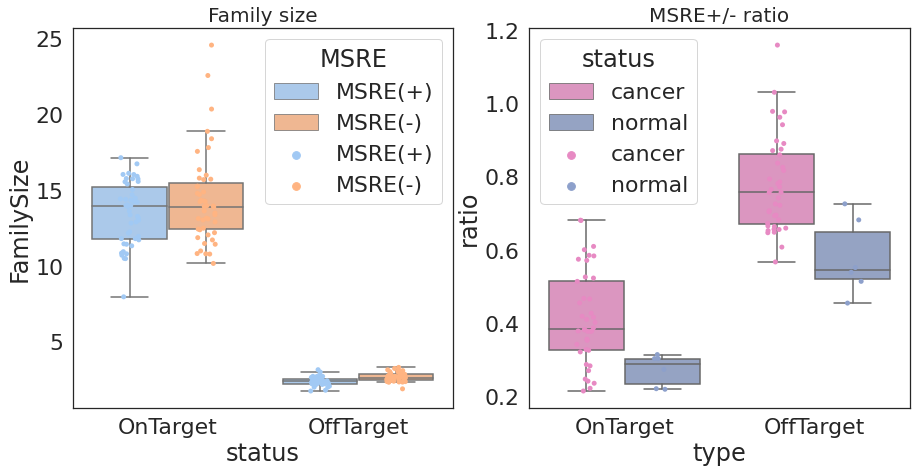

In [22]:
pyplot.rcParams['figure.figsize'] = [15, 7]
pyplot.rcParams["xtick.labelsize"] = 20
pyplot.rcParams["ytick.labelsize"] = 20
seaborn.set(font_scale=2)
seaborn.set_style(style='white') 
pname = "pastel"

_ = pyplot.subplot(1,2,1)
pd = DataFrame(data={"FamilySize": [], "MSRE": [], "status": []})
for ms in msre_status:
    md = indata[indata["MSRE"]==ms]
    pd = pd.append(DataFrame(data={"FamilySize": md["ontarget_fam_size"], "MSRE": ms, "status":"OnTarget"}))
    pd = pd.append(DataFrame(data={"FamilySize": md["offtarget_fam_size"], "MSRE": ms, "status":"OffTarget"}))
ax_box = seaborn.boxplot(x="status", y="FamilySize", hue="MSRE", data=pd, showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="status", y="FamilySize", hue="MSRE", data=pd, dodge=True, palette=pname)
_ = pyplot.title("Family size", fontsize=20)

_ = pyplot.subplot(1,2,2)
cancer_status = []
on_ratios = []
off_ratios = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    md = indata[indata["accession_id"]==a_id]
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = dpos["ontarget_sum"].item() / dpos["input"].item()
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = dneg["ontarget_sum"].item() / dpos["input"].item()
    rt = rpos/rneg
    on_ratios.append(rt)
    
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = dpos["offtarget_sum"].item() / dpos["input"].item()
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = dneg["offtarget_sum"].item() / dpos["input"].item()
    rt = rpos/rneg
    off_ratios.append(rt)
    if md[md["MSRE"]=="MSRE(+)"]["status"].item()=="normal":
        cancer_status.append("normal")
    else:
        cancer_status.append("cancer")
        
rd = DataFrame(data={"ratio":on_ratios, "status":cancer_status, "type": "OnTarget"})
rd = rd.append(DataFrame(data={"ratio":off_ratios, "status":cancer_status, "type": "OffTarget"}))

ax_box = seaborn.boxplot(x="type", y="ratio", hue="status", data=rd, showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="type", y="ratio", hue="status", data=rd, dodge=True, palette=cn_color)
_ = pyplot.title("MSRE+/- ratio", fontsize=20)

In [ ]:
%%bash
less /ghds/groups/algorithms/scratch/tjiang/methylome/Resource/methylome_region/hyper_validated_targets_with_control.tsv | \
 grep -i control | bedtools sort -i > mcm_pos_controls.bed

## calculate min reads required

In [29]:
nm = indata[indata["status"]=="normal"]
nm_plus = nm[nm["MSRE"]=="MSRE(+)"]
nm_minus = nm[nm["MSRE"]=="MSRE(-)"]

plus_mean = mean(nm_plus["ontarget_sum"].div(nm_plus["input"]))
plus_sd = std(nm_plus["ontarget_sum"].div(nm_plus["input"]))
plus_offtarget_mean = mean(nm_plus["offtarget_sum"].div(nm_plus["input"]))

minus_mean = mean(nm_minus["ontarget_sum"].div(nm_minus["input"]))
minus_sd = std(nm_minus["ontarget_sum"].div(nm_minus["input"]))
minus_offtarget_mean = mean(nm_minus["offtarget_sum"].div(nm_minus["input"]))

input_ng = 30
min_ontarget_plus = plus_mean + 5 * plus_sd
min_ontarget_minus = minus_mean + 5 * minus_sd
min_ontarget_plus_reads = min_ontarget_plus * 3 * 0.75 * input_ng
min_ontarget_minus_reads = min_ontarget_minus * 3 * 0.75 * input_ng

print(["+"] + list(map(int, [plus_mean, min_ontarget_plus, min_ontarget_plus_reads, plus_offtarget_mean])))
print(["-"] + list(map(int, [minus_mean, min_ontarget_minus, min_ontarget_minus_reads, minus_offtarget_mean])))

['+', 12965, 19421, 1310974, 384943]
['-', 49046, 104514, 7054737, 672334]


In [24]:
# fit regression of offtarget~pos_ctrl
pdata = read_csv('pos_control_counts_unfiltered.tsv', header=0, sep='\t')
pdata.columns = ["run_sample_id", "pos_mols", "pos_reads", "offtarget_reads"]
pdata = merge(pdata, f2, on=["run_sample_id"])

In [25]:
mean(pdata["pos_mols"].div(pdata["input"]))

11338.793908614249

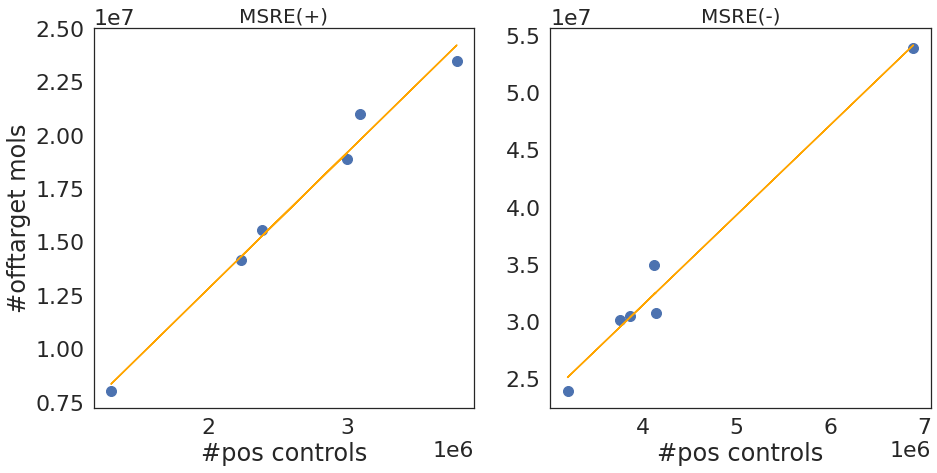

In [26]:
from sklearn import linear_model, metrics
from numpy import reshape

dreg = pdata[pdata["cancer_type"]=="normal"]
models = {}
index = 1
for ms in ["MSRE(+)", "MSRE(-)"]:
    xd = dreg[dreg["MSRE"]==ms]
    xvals_list = xd["pos_reads"].to_list()
    xvals = reshape(xvals_list, (-1, 1))
    yvals = xd["offtarget_reads"].to_list()
    model = linear_model.LinearRegression(normalize=False)
    model.fit(xvals, yvals)
    models[ms] = model
    
    pred_y = model.predict(xvals)
    _ = pyplot.subplot(1,2,index)
    _ = pyplot.scatter(xvals_list, yvals, s=100)
    _ = pyplot.plot(xvals_list, pred_y, color="orange")
    _ = pyplot.xlabel("#pos controls")
    if index == 1:
        _ = pyplot.ylabel("#offtarget mols")
    _ = pyplot.title(ms, fontsize=20)
    
    index += 1

In [27]:
## offtarget requirement
normal_pd = pdata[pdata["cancer_type"]=="normal"]
avr_pos_mol_ng_plus = mean(normal_pd[normal_pd["MSRE"]=="MSRE(+)"]["pos_mols"].div(normal_pd[normal_pd["MSRE"]=="MSRE(+)"]["input"]))
plus_xval = avr_pos_mol_ng_plus * 3 * 0.75 * input_ng
offtarget_reads_plus = models["MSRE(+)"].predict(reshape([plus_xval], (-1, 1)))

avr_pos_mol_ng_minus = mean(normal_pd[normal_pd["MSRE"]=="MSRE(-)"]["pos_mols"].div(normal_pd[normal_pd["MSRE"]=="MSRE(-)"]["input"]))
minus_xval = avr_pos_mol_ng_minus * 3 * 0.75 * input_ng
offtarget_reads_minus = models["MSRE(-)"].predict(reshape([minus_xval], (-1, 1)))


print(["+"] + list(map(int, [plus_mean, min_ontarget_plus, min_ontarget_plus_reads, avr_pos_mol_ng_plus,
                             offtarget_reads_plus, min_ontarget_plus_reads+offtarget_reads_plus])))
print(["-"] + list(map(int, [minus_mean, min_ontarget_minus, min_ontarget_minus_reads, avr_pos_mol_ng_minus,
                             offtarget_reads_minus, min_ontarget_minus_reads+offtarget_reads_minus])))

['+', 12965, 19421, 1310974, 11149, 4882637, 6193612]
['-', 49046, 104514, 7054737, 14697, 7702360, 14757097]


## hypo/negative controls - simply methylome regions overlapping hypo

In [7]:
%%bash
less /ghds/omni_v2/tool/post-bip_resource/bip-products/panels/LDT_next_v1.0/MBD_control.bed | \
 grep HYPO_CONTROL | cut -f1-3 > raw-v6_hypo_ctrl.bed
cat /ghds/groups/algorithms/scratch/tjiang/methylome/Resource/methylome_region/hyper_validated_targets_with_control.tsv | \
 awk 'NR>1' | bedtools sort -i - | bedtools intersect -a - -b raw-v6_hypo_ctrl.bed -u > v6_hypo_ctrl.bed


In [8]:
hypo_regions = []
incsv = read_csv('v6_hypo_ctrl.bed', header=None, sep='\t')
for idx, d2 in incsv.iterrows():
    hypo_regions.append('_'.join(map(str, d2[:3])))
print(len(hypo_regions))

479


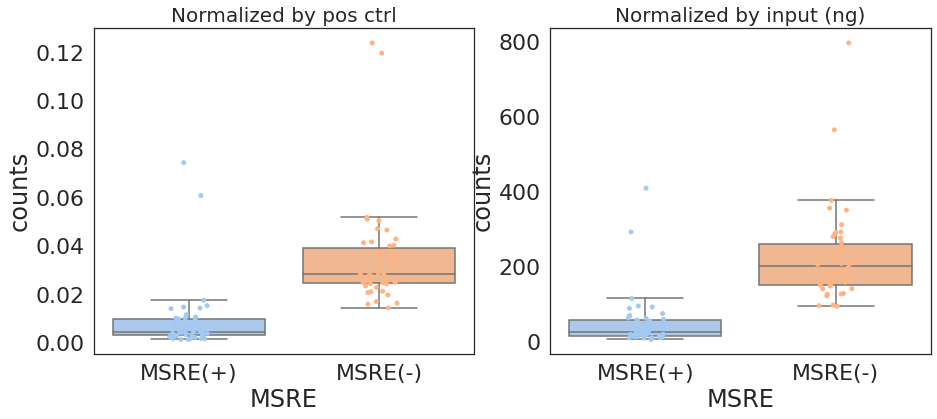

In [19]:
pyplot.rcParams['figure.figsize'] = [15, 6]
rd = DataFrame(data={"counts": [], "MSRE": [], "norm": []})

for nname in ["input", "ctrl_sum"]:
    for ms in msre_status:
        pd = mdata[(mdata["MSRE"]==ms) & (mdata["accession_id"]!="SC")]
        ct =  [i / j for i, j in zip(pd[hypo_regions].sum(axis=1).to_list(), pd[nname].to_list())]
        rd = rd.append(DataFrame(data={"counts":ct, "MSRE": ms, "norm": nname}))

_ = pyplot.subplot(1,2,1)
ax_box = seaborn.boxplot(x="MSRE", y="counts", data=rd[rd["norm"]=="ctrl_sum"], showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="MSRE", y="counts", data=rd[rd["norm"]=="ctrl_sum"], dodge=True, palette=pname)
_ = pyplot.title("Normalized by pos ctrl", fontsize=20)

_ = pyplot.subplot(1,2,2)
ax_box = seaborn.boxplot(x="MSRE", y="counts", data=rd[rd["norm"]=="input"], showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="MSRE", y="counts", data=rd[rd["norm"]=="input"], dodge=True, palette=pname)
_ = pyplot.title("Normalized by input (ng)", fontsize=20)

In [57]:
mdata[hypo_regions].head(10)

,1_954769_956640,1_3817289_3818068,1_6258977_6259906,1_6672656_6675624,1_10534878_10535804,1_11796063_11796822,1_12676936_12677667,1_12677751_12678762,1_19536048_19537285,1_19922959_19924366,...,9_36190543_36191806,9_37464630_37466969,9_79008638_79010173,9_98637177_98638550,9_101017343_101018581,9_102583202_102585088,9_102668616_102669682,9_131217965_131219585,9_131938212_131941021,9_134000315_134001602
C0018262,8,9,8,21,9,3,15,11,10,11,...,18,18,14,14,6,22,5,35,25,12
C0018225,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
C0018228,0,0,0,0,0,0,1,0,0,1,...,1,0,1,0,0,0,6,0,0,1
C0018195,0,0,0,1,1,0,0,0,0,0,...,0,0,3,0,0,1,2,1,0,0
C0018193,0,0,0,0,1,0,0,0,1,3,...,0,1,1,0,0,0,1,0,0,0
C0018281,8,6,7,13,6,3,15,9,6,24,...,8,9,16,19,16,14,14,26,17,9
C0018202,0,0,0,0,1,0,0,0,1,1,...,4,1,1,2,0,2,3,2,1,1
C0018197,0,0,0,0,0,0,0,1,1,2,...,1,0,2,0,0,0,2,1,0,0
C0018248,0,1,6,10,6,1,6,1,16,12,...,8,26,9,7,5,13,8,37,13,3
C0018213,0,0,1,0,0,0,0,0,0,0,...,1,0,0,2,0,0,1,0,0,0


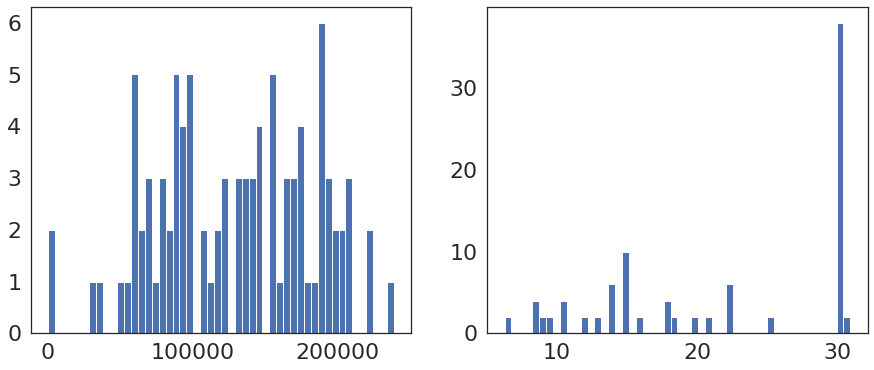

In [17]:
_ = pyplot.subplot(1,2,1)
_ = pyplot.hist(mdata["ctrl_sum"], bins=50)
_ = pyplot.subplot(1,2,2)
_ = pyplot.hist(mdata["input"], bins=50)

## hypo control, precise count (v6 setting)

In [7]:
indata = read_csv('hypo_control_precise_counts.tsv', header=0, sep='\t')
indata.columns = ["run_sample_id", "mc"]
indata.head(2)

,run_sample_id,mc
0,C0018190,73
1,C0018191,40


In [8]:
f2 = mdata[["accession_id", "cancer_type", "MSRE", "ctrl_sum", "input"]].copy()
f2["run_sample_id"] = f2.index
f2.head(2)

,accession_id,cancer_type,MSRE,ctrl_sum,input,run_sample_id
C0018262,A0309861,lung,MSRE(-),131897,22.2,C0018262
C0018225,A0322811,lung,MSRE(+),71197,14.9,C0018225


In [9]:
from pandas import merge
hypo_data = merge(indata, f2, on=["run_sample_id"])
print(hypo_data[hypo_data["accession_id"]=="SC"])
hypo_data = hypo_data[hypo_data["accession_id"]!="SC"]

   run_sample_id    mc accession_id cancer_type     MSRE ctrl_sum  input
0       C0018190    73           SC    SeraCare  MSRE(+)       90   15.0
47      C0018238  2639           SC    SeraCare  MSRE(-)      274   15.0


In [14]:
rd2

,ratio,status,norm
0,0.119403,cancer,input
0,0.119403,cancer,input
1,0.082707,cancer,input
0,0.119403,cancer,input
1,0.082707,cancer,input
...,...,...,...
41,0.076895,cancer,ctrl_sum
42,0.157732,normal,ctrl_sum
43,0.136513,cancer,ctrl_sum
44,0.092150,normal,ctrl_sum


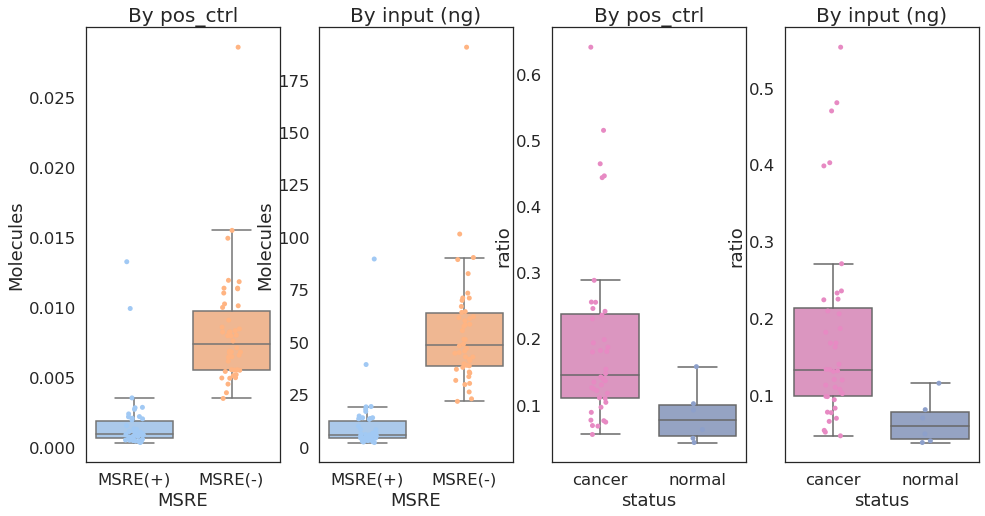

In [16]:
## normalizations and ratios
pyplot.rcParams['figure.figsize'] = [16, 8]
pyplot.rcParams["xtick.labelsize"] = 16
pyplot.rcParams["ytick.labelsize"] = 16

seaborn.set(font_scale=1.5)
seaborn.set_style(style='white') 

rd1 = DataFrame(data={"Molecules": [], "MSRE": [], "norm": []})
for nname in ["input", "ctrl_sum"]:
    for ms in ["MSRE(+)", "MSRE(-)"]:
        pd = hypo_data[(hypo_data["MSRE"]==ms) & (hypo_data["accession_id"]!="SC")]
        ct =  [i / j for i, j in zip(pd["mc"].to_list(), pd[nname].to_list())]
        rd1 = rd1.append(DataFrame(data={"Molecules": ct, "MSRE": ms, "norm": nname}))

rd2 = DataFrame(data={"ratio": [], "status": [], "norm": []})
for nname in ["input", "ctrl_sum"]:
    ratios = []
    cancer_status = []
    for a_id in accession_ids:
        if a_id == "SC":
            continue
        pd = hypo_data[hypo_data["accession_id"]==a_id]
        nplus = pd[pd["MSRE"]=="MSRE(+)"]["mc"].item() / pd[pd["MSRE"]=="MSRE(+)"][nname].item()
        nminus = pd[pd["MSRE"]=="MSRE(-)"]["mc"].item()/ pd[pd["MSRE"]=="MSRE(-)"][nname].item()
        ratios.append(nplus/nminus)
        st = "normal" if pd[pd["MSRE"]=="MSRE(+)"]["cancer_type"].item() == "normal" else "cancer"
        cancer_status.append(st)
    rd2 = rd2.append(DataFrame(data={"ratio": ratios, "status": cancer_status, "norm": nname, "status": cancer_status}))


_ = pyplot.subplot(1,4,1)
ax_box = seaborn.boxplot(x="MSRE", y="Molecules", data=rd1[rd1["norm"]=="ctrl_sum"], showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="MSRE", y="Molecules", data=rd1[rd1["norm"]=="ctrl_sum"], palette=pname)
_ = pyplot.title("By pos_ctrl", fontsize=20)
               
_ = pyplot.subplot(1,4,2)
ax_box = seaborn.boxplot(x="MSRE", y="Molecules", data=rd1[rd1["norm"]=="input"], showfliers=False, palette=pname)
ax_strip = seaborn.stripplot(x="MSRE", y="Molecules", data=rd1[rd1["norm"]=="input"], palette=pname)
_ = pyplot.title("By input (ng)", fontsize=20)

_ = pyplot.subplot(1,4,3)
ax_box = seaborn.boxplot(x="status", y="ratio", data=rd2[rd2["norm"]=="ctrl_sum"], showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="status", y="ratio", data=rd2[rd2["norm"]=="ctrl_sum"], palette=cn_color)
_ = pyplot.title("By pos_ctrl", fontsize=20)
               
_ = pyplot.subplot(1,4,4)
ax_box = seaborn.boxplot(x="status", y="ratio", data=rd2[rd2["norm"]=="input"], showfliers=False, palette=cn_color)
ax_strip = seaborn.stripplot(x="status", y="ratio", data=rd2[rd2["norm"]=="input"], palette=cn_color)
_ = pyplot.title("By input (ng)", fontsize=20)

## a merged plot

In [15]:
ratios = []
cancer_status = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    pd = hypo_data[hypo_data["accession_id"]==a_id]
    nplus = pd[pd["MSRE"]=="MSRE(+)"]["mc"].item() / pd[pd["MSRE"]=="MSRE(+)"]["ctrl_sum"].item()
    nminus = pd[pd["MSRE"]=="MSRE(-)"]["mc"].item()/ pd[pd["MSRE"]=="MSRE(-)"]["ctrl_sum"].item()
    ratios.append(nplus/nminus)
    st = "normal" if pd[pd["MSRE"]=="MSRE(+)"]["cancer_type"].item() == "normal" else "cancer"
    cancer_status.append(st)
rd = DataFrame(data={"ratio":ratios, "status":cancer_status, "type": "Neg_ctrl"})
raw_union_data = raw_union_data.append(rd)
raw_union_data.shape

(92, 3)

In [262]:
from statistics import median, mean
cancer_status = []
ratios = []
for a_id in accession_ids:
    if a_id == "SC":
        continue
    md = mdata[mdata["accession_id"]==a_id]
    dpos = md[md["MSRE"]=="MSRE(+)"]
    rpos = dpos[crc_dmr].div(dpos["input"].item())
    dneg = md[md["MSRE"]=="MSRE(-)"]
    rneg = dneg[crc_dmr].div(dneg["input"].item())
    rts = []
    for i,j in zip(rpos.values[0], rneg.values[0]):
        if j==0:
            continue
        r = i/j
        rts.append(r)
    ratios.append(median(rts))
    if md[md["MSRE"]=="MSRE(+)"]["cancer_type"].item()=="normal":
        #cancer_status += ["normal"] * len(rts)
        cancer_status.append("normal")
    else:
        #cancer_status += ["cancer"] * len(rts)
        cancer_status.append("cancer")
pd = DataFrame(data={"ratio":ratios, "status":cancer_status, "type": "DMRs"})

In [264]:
union_data = raw_union_data.append(pd)

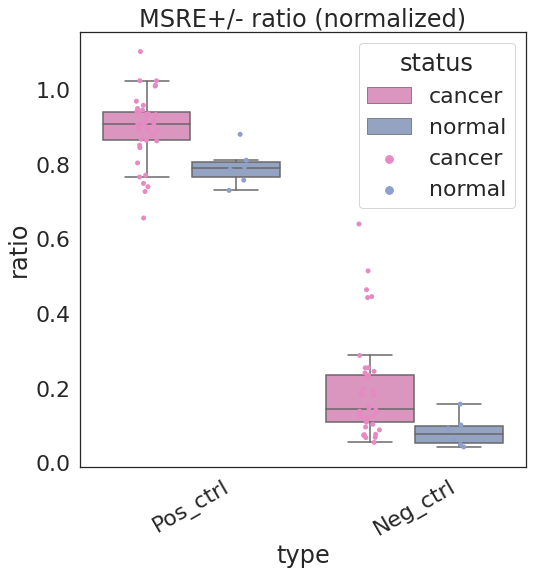

In [16]:
# a customized plot
pyplot.rcParams['figure.figsize'] = [8, 8]
pyplot.rcParams["xtick.labelsize"] = 20
pyplot.rcParams["ytick.labelsize"] = 20
seaborn.set(font_scale=2)
seaborn.set_style(style='white') 
pname = "pastel"
ax_box = seaborn.boxplot(x="type", y="ratio", hue="status", data=raw_union_data, showfliers = False, palette=cn_color)
ax_swarm = seaborn.stripplot(x="type", y="ratio", hue="status", data=raw_union_data, dodge=True, palette=cn_color)
_ = pyplot.setp(ax_box.get_xticklabels(), rotation=30)
_ = pyplot.title("MSRE+/- ratio (normalized)")

## CRC DMRs

In [1]:
%%bash
## check v6 CRC DMRs
less /ghds/groups/lunar/analysis/2020_11_03_MSRE_Clinical_Performance_YH/v6_regions_all.tsv | grep CRC_DMR | bedtools sort -i - > v6_crc_dmr.bed
cat /ghds/groups/algorithms/scratch/tjiang/methylome/Resource/methylome_region/hyper_validated_targets_with_control.tsv | awk 'NR>1' | bedtools sort -i - | bedtools intersect -a - -b v6_crc_dmr.bed -u > v6_crc_dmr.methylome.bed

In [ ]:
%%bash
# get other DMRs
./gen-dmrs.sh

In [5]:
crc_dmr = []
incsv = read_csv('v6_crc_dmr.methylome.bed', header=None, sep='\t')
for idx, d2 in incsv.iterrows():
    crc_dmr.append('_'.join(map(str, d2[:3])))
print(len(crc_dmr))

1270


In [55]:
fd = read_csv('cancer-list.txt', header=None, sep='\t')
cancers = fd[0].to_list()
cancers

['bladder',
 'breast',
 'CRC',
 'HNSCC',
 'lung',
 'melanoma',
 'pancrea',
 'prostate']

In [81]:
def load_region_names(fpath):
    incsv = read_csv(fpath, header=None, sep='\t')
    rnames = []
    for idx, d2 in incsv.iterrows():
        rnames.append('_'.join(map(str, d2[:3])))
    return rnames

def gen_ratios(mdata, dmrs, ct):
    cdata = mdata[dmrs + ["MSRE", "ctrl_sum"]][mdata["cancer_type"]==ct].copy()
    cdata[dmrs] += 0.5
    cdata[dmrs] = cdata[dmrs].div(cdata.ctrl_sum.values, axis=0)
    cplus = cdata[cdata["MSRE"]=="MSRE(+)"].mean(axis=0)
    cminus = cdata[cdata["MSRE"]=="MSRE(-)"].mean(axis=0)
    
    ndata = mdata[dmrs + ["MSRE", "ctrl_sum"]][mdata["cancer_type"]=="normal"].copy()
    ndata[dmrs] += 0.5
    ndata[dmrs] = ndata[dmrs].div(ndata.ctrl_sum.values, axis=0)
    nplus = ndata[ndata["MSRE"]=="MSRE(+)"].mean(axis=0)
    nminus = ndata[ndata["MSRE"]=="MSRE(-)"].mean(axis=0)
    
    return log(cplus.div(nplus)), log(cminus.div(nminus))

crc_plus, crc_minus = gen_ratios(mdata, crc_dmr, "CRC")
pd = DataFrame(data={"log_ratio": crc_plus, "status": "v6_CRC", "MSRE": "+"})
pd = pd.append(DataFrame(data={"log_ratio": crc_minus, "status": "v6_CRC", "MSRE": "-"}))

for ct in cancers:
    fpath = "dmrs/" + ct + ".dmr.bed"
    dmrs = load_region_names(fpath)
    rt_plus, rt_minus = gen_ratios(mdata, dmrs, ct)
    pd = pd.append(DataFrame(data={"log_ratio": rt_plus, "status": ct, "MSRE": "+"}))
    pd = pd.append(DataFrame(data={"log_ratio": rt_minus, "status": ct, "MSRE": "-"}))

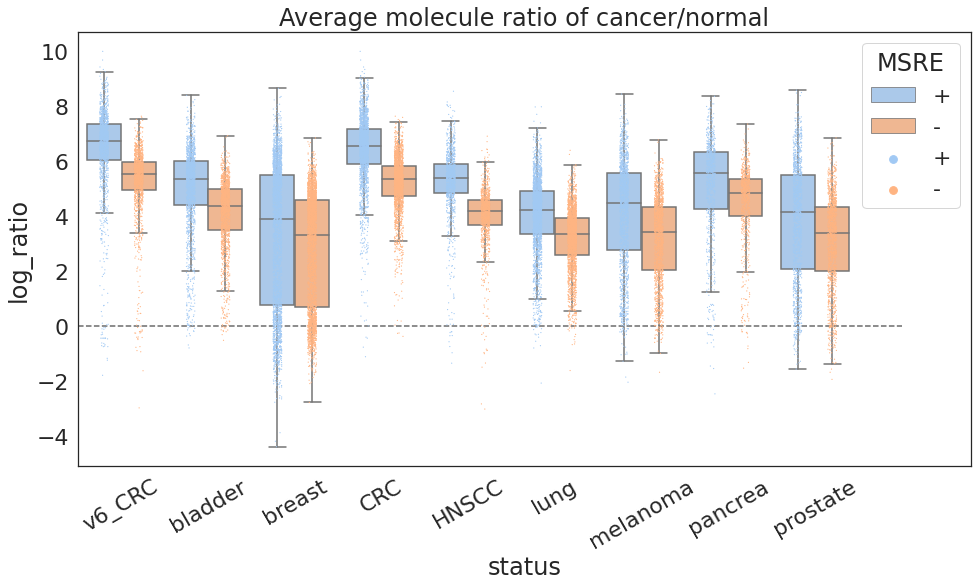

In [94]:
pyplot.rcParams['figure.figsize'] = [16, 8]
pyplot.rcParams["xtick.labelsize"] = 20
pyplot.rcParams["ytick.labelsize"] = 20
seaborn.set(font_scale=2)
seaborn.set_style(style='white') 
pname = "pastel"
ax_box = seaborn.boxplot(x="status", y="log_ratio", hue="MSRE", data=pd, showfliers = False, palette=pname)
ax_swarm = seaborn.stripplot(x="status", y="log_ratio", hue="MSRE", data=pd, size=1.2, dodge=True, palette=pname)
_ = pyplot.setp(ax_box.get_xticklabels(), rotation=30)
_ = pyplot.hlines(0, -0.5, 9, linestyles="dashed", color="dimgray")
#_ = pyplot.ylim(6,12)
_ = pyplot.xlim(-0.5,9.8)
_ = pyplot.title("Average molecule ratio of cancer/normal")

<ipython-input-31-8476c69d6a12>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  yvals = pd[mdata["cancer_type"]==ct][crc_dmr].div(pd[mdata["cancer_type"]==ct]["ctrl_sum"].values, axis=0)


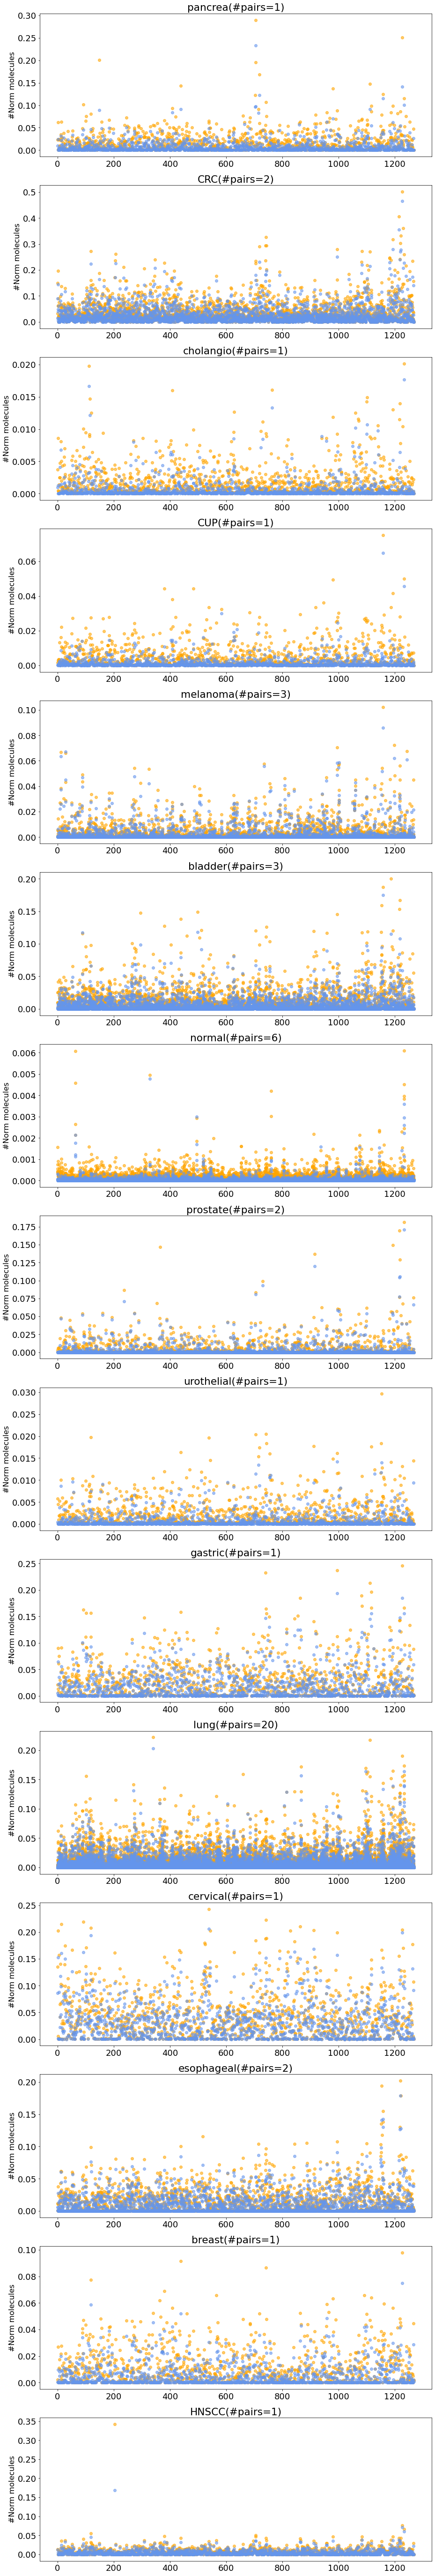

In [31]:
# manhattan-like plot
cancer_types = list(set(mdata["cancer_type"].values))
cancer_types.remove("SeraCare")
num_types = len(cancer_types)
idx = 1

status_colors = {"MSRE(+)": "cornflowerblue", "MSRE(-)": "orange"}

pyplot.rcParams['figure.figsize'] = [15, 100]
for ct in cancer_types:
    _ = pyplot.subplot(num_types,1,idx)
    for ms in msre_status:
        pd = mdata[mdata["MSRE"]==ms]
        xval = range(len(crc_dmr))
        yvals = pd[mdata["cancer_type"]==ct][crc_dmr].div(pd[mdata["cancer_type"]==ct]["ctrl_sum"].values, axis=0)
        for ii, d2 in yvals.iterrows():
            _ = pyplot.scatter(xval, d2, alpha=0.6, color=status_colors[ms])
    _ = pyplot.title(ct + "(#pairs=" + str(yvals.shape[0]) + ")")
    #_ = pyplot.ylim(0, 0.2)
    #_ = pyplot.yscale('log')
    #_ = pyplot.xlabel("DMRs", fontsize=16)
    _ = pyplot.ylabel("#Norm molecules", fontsize=16)
    #_ = pyplot.legend()
    idx += 1